In [2]:

pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Others
import shutil
import random

In [4]:
# Download dataset
od.download('https://www.kaggle.com/datasets/faudyanurul/potato')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: faudyanurul
Your Kaggle Key: ··········


100%|██████████| 185M/185M [00:11<00:00, 16.6MB/s]


In [5]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "potato/Potato/train",
    label_mode="categorical",
    class_names= ['Potato healthy', 'Potato leaf early blight', 'Potato leaf late blight'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "potato/Potato/valid",
    label_mode="categorical",
    class_names= ['Potato healthy', 'Potato leaf early blight', 'Potato leaf late blight'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 5907 files belonging to 3 classes.
==========================Validation Data====================
Found 1442 files belonging to 3 classes.


In [6]:
# All images will be rescaled by 1./255.and augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("potato/Potato/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("potato/Potato/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))


Found 5907 images belonging to 3 classes.
Found 1442 images belonging to 3 classes.


In [7]:
# Check GPU
!nvidia-smi

Wed Jun  7 02:49:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    28W /  70W |    389MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

MobileNetV2 Model 1

In [ ]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Potato_MobileNetV2_model1_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [ ]:
# Define DIY Model
MobileNetV2_model = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(3, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                           

In [ ]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_1 = MobileNetV2_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
296/296 [==============================] - ETA: 0s - loss: 0.3880 - accuracy: 0.9250
Epoch 1: val_accuracy improved from -inf to 0.31692, saving model to Potato_MobileNetV2_model1_Based_Augmented


296/296 [==============================] - 183s 457ms/step - loss: 0.3880 - accuracy: 0.9250 - val_loss: 11.6328 - val_accuracy: 0.3169 - lr: 0.0010
Epoch 2/100
296/296 [==============================] - ETA: 0s - loss: 0.1318 - accuracy: 0.9565
Epoch 2: val_accuracy improved from 0.31692 to 0.32732, saving model to Potato_MobileNetV2_model1_Based_Augmented


296/296 [==============================] - 129s 438ms/step - loss: 0.1318 - accuracy: 0.9565 - val_loss: 6.3826 - val_accuracy: 0.3273 - lr: 0.0010
Epoch 3/100
296/296 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9716
Epoch 3: val_accuracy improved from 0.32732 to 0.33634, saving model to Potato_MobileNetV2_model1_Based_Augmented


296/296 [==============================] - 129s 437ms/step - loss: 0.0694 - accuracy: 0.9716 - val_loss: 8.6796 - val_accuracy: 0.3363 - lr: 0.0010
Epoch 4/100
296/296 [==============================] - ETA: 0s - loss: 0.0958 - accuracy: 0.9641
Epoch 4: val_accuracy improved from 0.33634 to 0.77739, saving model to Potato_MobileNetV2_model1_Based_Augmented


296/296 [==============================] - 127s 430ms/step - loss: 0.0958 - accuracy: 0.9641 - val_loss: 0.5963 - val_accuracy: 0.7774 - lr: 0.0010
Epoch 5/100
296/296 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.9751
Epoch 5: val_accuracy did not improve from 0.77739
296/296 [==============================] - 102s 345ms/step - loss: 0.0642 - accuracy: 0.9751 - val_loss: 1.6515 - val_accuracy: 0.6782 - lr: 0.0010
Epoch 6/100
296/296 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9756
Epoch 6: val_accuracy did not improve from 0.77739
296/296 [==============================] - 100s 338ms/step - loss: 0.0523 - accuracy: 0.9756 - val_loss: 5.5747 - val_accuracy: 0.3925 - lr: 0.0010
Epoch 7/100
296/296 [==============================] - ETA: 0s - loss: 0.0701 - accuracy: 0.9743
Epoch 7: val_accuracy improved from 0.77739 to 0.87656, saving model to Potato_MobileNetV2_model1_Based_Augmented


296/296 [==============================] - 129s 437ms/step - loss: 0.0701 - accuracy: 0.9743 - val_loss: 0.3140 - val_accuracy: 0.8766 - lr: 0.0010
Epoch 8/100
296/296 [==============================] - ETA: 0s - loss: 0.0639 - accuracy: 0.9749
Epoch 8: val_accuracy improved from 0.87656 to 0.93828, saving model to Potato_MobileNetV2_model1_Based_Augmented


296/296 [==============================] - 127s 430ms/step - loss: 0.0639 - accuracy: 0.9749 - val_loss: 0.2060 - val_accuracy: 0.9383 - lr: 0.0010
Epoch 9/100
296/296 [==============================] - ETA: 0s - loss: 0.0759 - accuracy: 0.9717
Epoch 9: val_accuracy did not improve from 0.93828
296/296 [==============================] - 102s 346ms/step - loss: 0.0759 - accuracy: 0.9717 - val_loss: 1.0646 - val_accuracy: 0.5423 - lr: 0.0010
Epoch 10/100
296/296 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.9699
Epoch 10: val_accuracy did not improve from 0.93828
296/296 [==============================] - 100s 337ms/step - loss: 0.0750 - accuracy: 0.9699 - val_loss: 5.9246 - val_accuracy: 0.3169 - lr: 0.0010
Epoch 11/100
296/296 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 0.9711
Epoch 11: val_accuracy did not improve from 0.93828
296/296 [==============================] - 102s 343ms/step - loss: 0.0726 - accuracy: 0.9711 - val_loss: 1.9

296/296 [==============================] - 128s 432ms/step - loss: 0.0388 - accuracy: 0.9829 - val_loss: 0.0721 - val_accuracy: 0.9834 - lr: 1.0000e-04
Epoch 15/100
296/296 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9848
Epoch 15: val_accuracy improved from 0.98336 to 0.98960, saving model to Potato_MobileNetV2_model1_Based_Augmented


296/296 [==============================] - 124s 421ms/step - loss: 0.0394 - accuracy: 0.9848 - val_loss: 0.0404 - val_accuracy: 0.9896 - lr: 1.0000e-04
Epoch 16/100
296/296 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9849
Epoch 16: val_accuracy improved from 0.98960 to 0.99376, saving model to Potato_MobileNetV2_model1_Based_Augmented


296/296 [==============================] - 120s 407ms/step - loss: 0.0293 - accuracy: 0.9849 - val_loss: 0.0230 - val_accuracy: 0.9938 - lr: 1.0000e-04
Epoch 17/100
296/296 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.9873
Epoch 17: val_accuracy improved from 0.99376 to 0.99653, saving model to Potato_MobileNetV2_model1_Based_Augmented


296/296 [==============================] - 116s 392ms/step - loss: 0.0292 - accuracy: 0.9873 - val_loss: 0.0153 - val_accuracy: 0.9965 - lr: 1.0000e-04
Epoch 18/100
296/296 [==============================] - ETA: 0s - loss: 0.0323 - accuracy: 0.9858
Epoch 18: val_accuracy did not improve from 0.99653
296/296 [==============================] - 92s 309ms/step - loss: 0.0323 - accuracy: 0.9858 - val_loss: 0.0190 - val_accuracy: 0.9965 - lr: 1.0000e-04
Epoch 19/100
296/296 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9865
Epoch 19: val_accuracy did not improve from 0.99653
296/296 [==============================] - 93s 313ms/step - loss: 0.0272 - accuracy: 0.9865 - val_loss: 0.0197 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 20/100
296/296 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9876
Epoch 20: val_accuracy did not improve from 0.99653
296/296 [==============================] - 92s 310ms/step - loss: 0.0267 - accuracy: 0.9876 - va

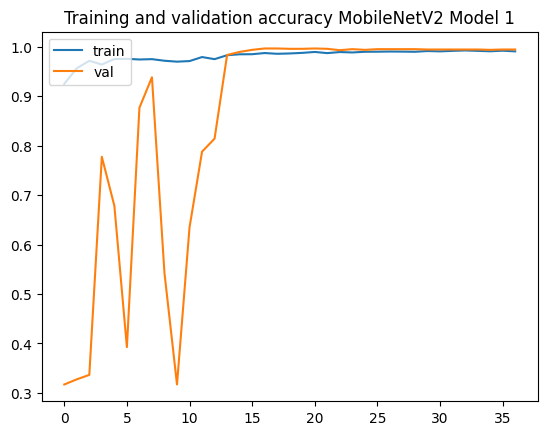

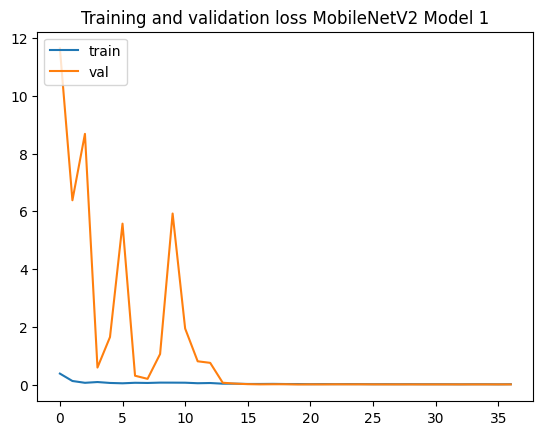

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_1.history['accuracy' ]
val_acc  = history_MobileNetV2_model_1.history['val_accuracy' ]
loss     = history_MobileNetV2_model_1.history['loss' ]
val_loss = history_MobileNetV2_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
!zip -r /content/Potato_MobileNetV2_model1_Based_Augmented.zip /content/Potato_MobileNetV2_model1_Based_Augmented

  adding: content/Potato_MobileNetV2_model1_Based_Augmented/ (stored 0%)
  adding: content/Potato_MobileNetV2_model1_Based_Augmented/saved_model.pb (deflated 91%)
  adding: content/Potato_MobileNetV2_model1_Based_Augmented/fingerprint.pb (stored 0%)
  adding: content/Potato_MobileNetV2_model1_Based_Augmented/variables/ (stored 0%)
  adding: content/Potato_MobileNetV2_model1_Based_Augmented/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: content/Potato_MobileNetV2_model1_Based_Augmented/variables/variables.index (deflated 76%)
  adding: content/Potato_MobileNetV2_model1_Based_Augmented/keras_metadata.pb (deflated 96%)
  adding: content/Potato_MobileNetV2_model1_Based_Augmented/assets/ (stored 0%)


MobileNetV2 Model 2

In [10]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Potato_MobileNetV2_model2_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [11]:
# Define DIY Model
MobileNetV2_2 = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(3, activation='softmax') 
  ])


# Compile Model
MobileNetV2_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_2.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                           

In [12]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_2 = MobileNetV2_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)


Epoch 1/100
296/296 [==============================] - ETA: 0s - loss: 0.2318 - accuracy: 0.9201
Epoch 1: val_accuracy improved from -inf to 0.33218, saving model to Potato_MobileNetV2_model2_Based_Augmented


296/296 [==============================] - 156s 387ms/step - loss: 0.2318 - accuracy: 0.9201 - val_loss: 9.1545 - val_accuracy: 0.3322 - lr: 0.0010
Epoch 2/100
296/296 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 0.9660
Epoch 2: val_accuracy did not improve from 0.33218
296/296 [==============================] - 90s 303ms/step - loss: 0.0966 - accuracy: 0.9660 - val_loss: 18.7264 - val_accuracy: 0.3162 - lr: 0.0010
Epoch 3/100
296/296 [==============================] - ETA: 0s - loss: 0.1392 - accuracy: 0.9575
Epoch 3: val_accuracy improved from 0.33218 to 0.35784, saving model to Potato_MobileNetV2_model2_Based_Augmented


296/296 [==============================] - 111s 376ms/step - loss: 0.1392 - accuracy: 0.9575 - val_loss: 6.6755 - val_accuracy: 0.3578 - lr: 0.0010
Epoch 4/100
296/296 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.9694
Epoch 4: val_accuracy improved from 0.35784 to 0.46463, saving model to Potato_MobileNetV2_model2_Based_Augmented


296/296 [==============================] - 112s 380ms/step - loss: 0.0707 - accuracy: 0.9694 - val_loss: 10.0195 - val_accuracy: 0.4646 - lr: 0.0010
Epoch 5/100
296/296 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9733
Epoch 5: val_accuracy did not improve from 0.46463
296/296 [==============================] - 88s 298ms/step - loss: 0.0720 - accuracy: 0.9733 - val_loss: 33.3440 - val_accuracy: 0.3162 - lr: 0.0010
Epoch 6/100
296/296 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9722
Epoch 6: val_accuracy improved from 0.46463 to 0.84189, saving model to Potato_MobileNetV2_model2_Based_Augmented


296/296 [==============================] - 112s 378ms/step - loss: 0.0689 - accuracy: 0.9722 - val_loss: 1.6708 - val_accuracy: 0.8419 - lr: 0.0010
Epoch 7/100
296/296 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.9709
Epoch 7: val_accuracy did not improve from 0.84189
296/296 [==============================] - 91s 306ms/step - loss: 0.0826 - accuracy: 0.9709 - val_loss: 2.7010 - val_accuracy: 0.7524 - lr: 0.0010
Epoch 8/100
296/296 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.9533
Epoch 8: val_accuracy did not improve from 0.84189
296/296 [==============================] - 87s 295ms/step - loss: 0.1253 - accuracy: 0.9533 - val_loss: 29.3941 - val_accuracy: 0.3162 - lr: 0.0010
Epoch 9/100
296/296 [==============================] - ETA: 0s - loss: 0.0736 - accuracy: 0.9741
Epoch 9: val_accuracy did not improve from 0.84189
296/296 [==============================] - 88s 299ms/step - loss: 0.0736 - accuracy: 0.9741 - val_loss: 6.5570 - 

296/296 [==============================] - 112s 378ms/step - loss: 0.0323 - accuracy: 0.9849 - val_loss: 0.3532 - val_accuracy: 0.9307 - lr: 1.0000e-04
Epoch 14/100
296/296 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.9846
Epoch 14: val_accuracy improved from 0.93065 to 0.96741, saving model to Potato_MobileNetV2_model2_Based_Augmented


296/296 [==============================] - 113s 381ms/step - loss: 0.0305 - accuracy: 0.9846 - val_loss: 0.1208 - val_accuracy: 0.9674 - lr: 1.0000e-04
Epoch 15/100
296/296 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9859
Epoch 15: val_accuracy improved from 0.96741 to 0.98405, saving model to Potato_MobileNetV2_model2_Based_Augmented


296/296 [==============================] - 112s 380ms/step - loss: 0.0317 - accuracy: 0.9859 - val_loss: 0.0458 - val_accuracy: 0.9840 - lr: 1.0000e-04
Epoch 16/100
296/296 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9858
Epoch 16: val_accuracy did not improve from 0.98405
296/296 [==============================] - 90s 305ms/step - loss: 0.0279 - accuracy: 0.9858 - val_loss: 0.0519 - val_accuracy: 0.9834 - lr: 1.0000e-04
Epoch 17/100
296/296 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.9868
Epoch 17: val_accuracy improved from 0.98405 to 0.99515, saving model to Potato_MobileNetV2_model2_Based_Augmented


296/296 [==============================] - 112s 378ms/step - loss: 0.0302 - accuracy: 0.9868 - val_loss: 0.0130 - val_accuracy: 0.9951 - lr: 1.0000e-04
Epoch 18/100
296/296 [==============================] - ETA: 0s - loss: 0.0255 - accuracy: 0.9881
Epoch 18: val_accuracy improved from 0.99515 to 0.99653, saving model to Potato_MobileNetV2_model2_Based_Augmented


296/296 [==============================] - 114s 385ms/step - loss: 0.0255 - accuracy: 0.9881 - val_loss: 0.0103 - val_accuracy: 0.9965 - lr: 1.0000e-04
Epoch 19/100
296/296 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9880
Epoch 19: val_accuracy did not improve from 0.99653
296/296 [==============================] - 88s 297ms/step - loss: 0.0245 - accuracy: 0.9880 - val_loss: 0.0139 - val_accuracy: 0.9965 - lr: 1.0000e-04
Epoch 20/100
296/296 [==============================] - ETA: 0s - loss: 0.0310 - accuracy: 0.9873
Epoch 20: val_accuracy did not improve from 0.99653
296/296 [==============================] - 89s 300ms/step - loss: 0.0310 - accuracy: 0.9873 - val_loss: 0.0110 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 21/100
296/296 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 0.9880
Epoch 21: val_accuracy did not improve from 0.99653
296/296 [==============================] - 88s 296ms/step - loss: 0.0247 - accuracy: 0.9880 - va

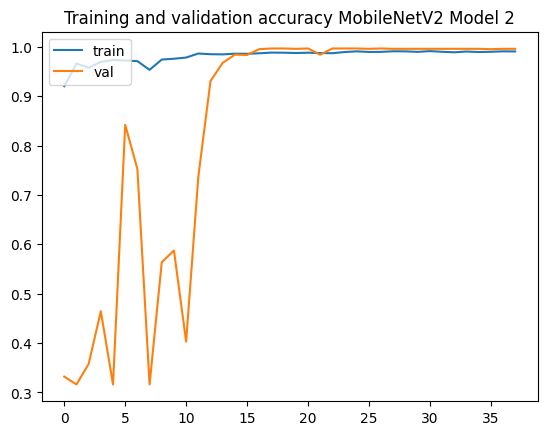

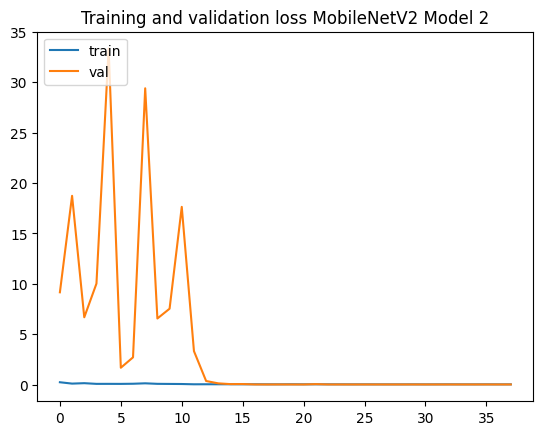

In [13]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_2.history['accuracy' ]
val_acc  = history_MobileNetV2_model_2.history['val_accuracy' ]
loss     = history_MobileNetV2_model_2.history['loss' ]
val_loss = history_MobileNetV2_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')

In [14]:
!zip -r /content/Potato_MobileNetV2_model2_Based_Augmented.zip /content/Potato_MobileNetV2_model2_Based_Augmented

  adding: content/Potato_MobileNetV2_model2_Based_Augmented/ (stored 0%)
  adding: content/Potato_MobileNetV2_model2_Based_Augmented/saved_model.pb (deflated 91%)
  adding: content/Potato_MobileNetV2_model2_Based_Augmented/fingerprint.pb (stored 0%)
  adding: content/Potato_MobileNetV2_model2_Based_Augmented/variables/ (stored 0%)
  adding: content/Potato_MobileNetV2_model2_Based_Augmented/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/Potato_MobileNetV2_model2_Based_Augmented/variables/variables.index (deflated 76%)
  adding: content/Potato_MobileNetV2_model2_Based_Augmented/keras_metadata.pb (deflated 96%)
  adding: content/Potato_MobileNetV2_model2_Based_Augmented/assets/ (stored 0%)
